In [7]:
import numpy as np

In [8]:
from blg_strain.hamiltonian import Hfunc

In [9]:
kxlims=[-0.35e9, .35e9]
kylims=[-0.35e9, .35e9]
Nkx, Nky = 1000, 1000

kx = np.linspace(kxlims[0], kxlims[1], Nkx)
ky = np.linspace(kylims[0], kylims[1], Nky)

Kx, Ky = np.meshgrid(kx, ky, indexing='ij')

# Eigenvalues of Hamiltonian
calculating eigenvalues is the slowest step

In [4]:
%%timeit
H = Hfunc(Kx, Ky)
H = H.transpose(2,3,0,1) # put the 4x4 in the last 2 dims for eigh

393 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
H = Hfunc(Kx, Ky)
H = H.transpose(2,3,0,1) # put the 4x4 in the last 2 dims for eigh

In [7]:
%%timeit
E, Psi = np.linalg.eigh(H)  # using eigh for Hermitian
                            # eigenvalues are real and sorted (low to high)
# Shapes - E: Nkx x Nky x 4, Psi: Nkx x Nky x 4 x 4

3.59 s ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
E, Psi = np.linalg.eigh(H)

In [12]:
%%timeit
E2 = E.transpose(2,0,1) # put the kx,ky points in last 2 dims
Psi2 = Psi.transpose(2,3,0,1) # put the kx,ky points in last 2 dims
# now E[:, 0, 0] is a length-4 array of eigenvalues

579 ns ± 4.96 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
E = E.transpose(2,0,1) # put the kx,ky points in last 2 dims
Psi = Psi.transpose(2,3,0,1) # put the kx,ky points in last 2 dims

In [16]:
%%timeit
multiplier = 2 * (Psi[0, :, :, :].real > 0) - 1  # shape 4 x Nkx x Nky
Psi2 = Psi* multiplier 
Psi2 = Psi2.transpose((1,0,2,3))

216 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
multiplier = 2 * (Psi[0, :, :, :].real > 0) - 1  # shape 4 x Nkx x Nky
Psi *= multiplier 
Psi = Psi.transpose((1,0,2,3))

# Berry

In [8]:
from blg_strain.hamiltonian import H_dkx, H_dky

In [9]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [24]:
%%timeit
psi_n = Psi[0]
psi_m = Psi[1]
prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

396 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%timeit
Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

77.7 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%%timeit
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.41 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

Non-looping version:

In [40]:
%%timeit
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

10.2 s ± 384 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

Looping `tensordot` version - memory error!

In [49]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [ ]:
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

In [57]:
prod1 = np.tensordot(psi_n.conj(), hdkx, axes=[[0],[0]])
prod2 = np.tensordot(prod1, psi_m, axes=[[-1],[0]])

MemoryError: 

`opt_einsum` package - no difference using numpy backend

In [12]:
from opt_einsum import contract

In [ ]:
hdkx, hdky = H_dkx(1), H_dky()  # 4x4 matrices

Omega = np.zeros_like(E)  # 4 x Nkx x Nky
Mu = np.zeros_like(E)

In [45]:
%%timeit
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = contract('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = contract('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.52 s ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%prun
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = contract('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = contract('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

In [16]:
psi_n = Psi[0]
psi_m = Psi[1]

In [17]:
%timeit prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)
%timeit prod1 = contract('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)

146 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
153 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


tensorflow backend?

In [35]:
import tensorflow as tf

In [30]:
from opt_einsum import contract_expression, contract

In [16]:
psi_n=Psi[0]
psi_m=Psi[1]

In [17]:
expr = contract_expression('ijk,il,ljk->jk', psi_n.shape, hdkx.shape, psi_n.shape)

In [32]:
%%timeit
prod1 = contract('ijk,il,ljk->jk', psi_n.conj().imag, hdkx, psi_m.real, optimize=True, backend='tensorflow')
prod2 = contract('ijk,il,ljk->jk', psi_n.conj().real, hdkx, psi_m.imag, optimize=True, backend='tensorflow')
# prod1 = expr(psi_n.conj().imag, hdkx, psi_m.real, backend='tensorflow')
# prod2 = expr(psi_n.conj().real, hdkx, psi_m.imag, backend='tensorflow')
prod = prod1 + prod2

205 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Showing real and imaginary parts explicitly, we have
# Imag[(a+bi)*H*(c+di)] = bHc +aHd

removed for loop with tensorflow

In [37]:
%%timeit
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products

prod1a = contract('nikl,ij,mjkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod1b = contract('nikl,ij,mjkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod1 = prod1a + prod1b

prod2a = contract('mikl,ij,njkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod2b = contract('mikl,ij,njkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod2 = prod2a + prod2b


# prod2 = contract('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi, backend='tensorflow')
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

5.01 s ± 441 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%%prun
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
for i in range(4):
    Enm[i,i,:,:] = 1e100 # make diagonal components go to zero when divide by Enm


# compute matrix products then sum the products

prod1a = contract('nikl,ij,mjkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod1b = contract('nikl,ij,mjkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod1 = prod1a + prod1b

prod2a = contract('mikl,ij,njkl->nmkl', Psi.conj().imag, hdkx, Psi.real, optimize=True, backend='tensorflow')
prod2b = contract('mikl,ij,njkl->nmkl', Psi.conj().real, hdkx, Psi.imag, optimize=True, backend='tensorflow')
prod2 = prod2a + prod2b


# prod2 = contract('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi, backend='tensorflow')
Omega = np.sum(np.imag(prod1*prod2/Enm**2), axis=1)  # sum over m
Mu = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

In [50]:
%%timeit
for n, (e_n, psi_n) in enumerate(zip(E, Psi)):
    for m, (e_m, psi_m) in enumerate(zip(E, Psi)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n.conj(), hdkx, psi_m, optimize=True)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m.conj(), hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.14 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
Psi_conj = Psi.conj()

for n, (e_n, psi_n, psi_n_conj) in enumerate(zip(E, Psi, Psi_conj)):
    for m, (e_m, psi_m_conj) in enumerate(zip(E, Psi_conj)):
        if n == m: # sum runs over n != m
            continue

        prod1 = np.einsum('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
        prod2 = np.einsum('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)

        Omega[n] += np.imag(prod1 * prod2 / (e_n - e_m) ** 2)
        Mu[n] += np.imag(prod1 * prod2 / (e_n - e_m))

4.51 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
prod1 = np.einsum('ijk,il,ljk->jk', psi_n_conj, hdkx, psi_m, optimize=True)
prod2 = np.einsum('ijk,il,ljk->jk', psi_m_conj, hdky, psi_n, optimize=True)


In [57]:
prod1.shape

(1000, 1000)

In [59]:
import matplotlib.pyplot as plt

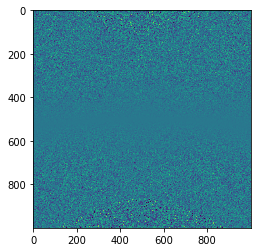

In [65]:
fig, ax = plt.subplots()
ax.imshow(prod2.imag)

## rewrite einsum to eliminate for loop?

In [12]:
E.shape

(4, 1000, 1000)

In [14]:
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
Enm.shape

(4, 4, 1000, 1000)

In [21]:
for i in range(4):
    Enm[i,i,:,:] = 1e100
# when dividing by Enm, diagonal components (n=m) will go to zero

In [16]:
# BAD - these sum before multiplying the two inner products
prod1 = np.einsum('nikl,ij,mjkl->kl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->kl', Psi.conj(), hdky, Psi)

In [ ]:
# this takes too long/hangs
prod = np.einsum('nikl,ij,mjkl,nokl,op,mpkl->kl', Psi.conj(), hdkx, Psi, Psi.conj(), hdky, Psi/Enm)

In [49]:
%%prun
# compute matrix products then sum the products
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
prod = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

In [27]:
prod.shape

(4, 1000, 1000)

In [ ]:
Omega2 = np.imag(prod1 * prod2)

In [65]:
E = np.array([1, 2, 3, 4])

In [69]:
E.reshape(4,1)

array([[1],
       [2],
       [3],
       [4]])

In [68]:
E.reshape(4,1) - E.reshape(1,4)

array([[ 0, -1, -2, -3],
       [ 1,  0, -1, -2],
       [ 2,  1,  0, -1],
       [ 3,  2,  1,  0]])

In [ ]:
Omega = np.imag(prod1 * prod2 / )

In [33]:
import matplotlib.pyplot as plt

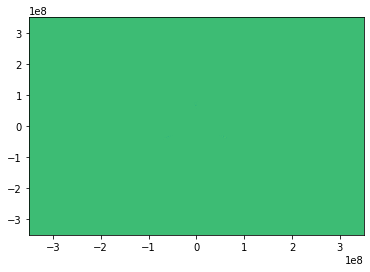

In [36]:
fig, ax = plt.subplots()
ax.pcolormesh(kx, ky, Mu[2])

In [38]:
Mu[0,27,0], prod[0,27,0]

(-2.872962451952862e-34, -2.872962451952862e-34)

# Multiprocessing

In [6]:
import multiprocessing
import numpy as np

In [7]:
from blg_strain.bands import get_bands

In [8]:
import time

In [12]:
times = []
Ns = [1, 3, 5, 10, 30, 50]
for N in Ns:
    t0 = time.time()
    deltas = np.linspace(0,0.02, N)

    jobs = []

    for delta in deltas:
        t = multiprocessing.Process(target=get_bands, kwargs={'delta':delta})
        jobs.append(t)
        t.start()
    #     threads.append(t)
    for t in jobs:
        t.join()
    times.append(time.time()-t0)

In [13]:
import matplotlib.pyplot as plt

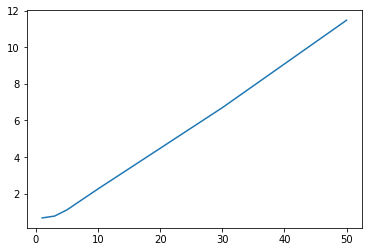

In [14]:
fig, ax = plt.subplots()
ax.plot(Ns, times)

In [3]:
def f(delta):
    return delta

In [6]:
def f(delta):
    return get_bands(delta=delta)

In [4]:
kx, ky, Kx, Ky, E, Psi, Omega, Mu = get_bands()

## multiprocessing Pool

In [1]:
from multiprocessing import Pool
from functools import partial
from blg_strain.bands import get_bands

In [2]:
def f(delta):
    return get_bands(Nkx=10, Nky=10, delta=delta)

In [1]:
if __name__ == '__main':
    pool = Pool(4)
    results = pool.map(f, deltas)

In [ ]:
pool()

In [3]:
from blg_strain.multi import pool_deltas

In [4]:
%%timeit
pool_deltas()

1.34 s ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
deltas = [0,0.01,0.02, 0.03, 0.04]

In [6]:
%%timeit
for delta in deltas:
    get_bands(Nkx=200, Nky=200, delta=delta)

1.86 s ± 6.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
outs = []
with Pool(4) as p:
    outs.append(p.map(f, [0,0.01,0.02, 0.03, 0.04]))

In [5]:
from functools import partial

In [8]:
f = partial(get_bands)

In [10]:
f(kxlims=3)

TypeError: 'int' object is not subscriptable

# Restart - does numerical precision change things?

In [12]:
import numpy as np

In [13]:
from blg_strain.hamiltonian import Hfunc

In [14]:
kxlims=[-0.35e9, .35e9]
kylims=[-0.35e9, .35e9]
Nkx, Nky = 1000, 1000

kx = np.linspace(kxlims[0], kxlims[1], Nkx)
ky = np.linspace(kylims[0], kylims[1], Nky)

Kx, Ky = np.meshgrid(kx, ky, indexing='ij')

# Eigenvalues of Hamiltonian
calculating eigenvalues is the slowest step

In [15]:
H = Hfunc(Kx, Ky)
H = H.transpose(2,3,0,1) # put the 4x4 in the last 2 dims for eigh

In [19]:
H.astype('complex64')

array([[[[-0.        +0.j        , -0.02833462-0.02833462j,
           0.        +0.j        , -0.2356993 +0.2356993j ],
         [-0.02833462+0.02833462j,  0.        +0.j        ,
          -0.2356993 -0.2356993j ,  0.        +0.j        ],
         [ 0.        +0.j        , -0.2356993 +0.2356993j ,
           0.        +0.j        ,  0.381     +0.j        ],
         [-0.2356993 -0.2356993j ,  0.        +0.j        ,
           0.381     +0.j        ,  0.        +0.j        ]],

        [[-0.        +0.j        , -0.02833462-0.02827789j,
           0.        +0.j        , -0.2356993 +0.23522742j],
         [-0.02833462+0.02827789j,  0.        +0.j        ,
          -0.2356993 -0.23522742j,  0.        +0.j        ],
         [ 0.        +0.j        , -0.2356993 +0.23522742j,
           0.        +0.j        ,  0.381     +0.j        ],
         [-0.2356993 -0.23522742j,  0.        +0.j        ,
           0.381     +0.j        ,  0.        +0.j        ]],

        [[-0.        +0.j   

In [25]:
H

array([[[[-0.        +0.j        , -0.02833462-0.02833462j,
           0.        +0.j        , -0.23569929+0.23569929j],
         [-0.02833462+0.02833462j,  0.        +0.j        ,
          -0.23569929-0.23569929j,  0.        +0.j        ],
         [ 0.        +0.j        , -0.23569929+0.23569929j,
           0.        +0.j        ,  0.381     +0.j        ],
         [-0.23569929-0.23569929j,  0.        +0.j        ,
           0.381     +0.j        ,  0.        +0.j        ]],

        [[-0.        +0.j        , -0.02833462-0.02827789j,
           0.        +0.j        , -0.23569929+0.23522742j],
         [-0.02833462+0.02827789j,  0.        +0.j        ,
          -0.23569929-0.23522742j,  0.        +0.j        ],
         [ 0.        +0.j        , -0.23569929+0.23522742j,
           0.        +0.j        ,  0.381     +0.j        ],
         [-0.23569929-0.23522742j,  0.        +0.j        ,
           0.381     +0.j        ,  0.        +0.j        ]],

        [[-0.        +0.j   

In [20]:
%%timeit
E, Psi = np.linalg.eigh(H)

5.45 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
E, Psi = np.linalg.eigh(H.astype('complex64'))

5.72 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Can we rewrite einsum using `.dot()`?

In [62]:
A = np.random.rand(4,5, 5)
B = 3* np.random.rand(4,5, 5)
hdkx = np.random.rand(4,4)

In [63]:
prod1 = np.einsum('ijk,il,ljk->jk', A, hdkx, B, optimize=True)

In [64]:
prod1

array([[ 9.97945396,  9.54654258,  5.09684468, 10.86223281,  4.80920012],
       [ 1.35552478,  7.84465709,  3.07077416,  6.58497795,  4.83971964],
       [13.92462496,  1.7662898 ,  4.86695409,  2.56850566,  4.74395591],
       [ 7.317954  ,  7.84065415,  3.70896968,  1.94125876,  1.82228105],
       [ 8.21335227,  3.38632269, 14.59200523,  4.2439463 ,  3.7883336 ]])

In [65]:
hdkxB = np.tensordot(hdkx, B, axes=([1], [0]))
prod2 = np.sum(A*hdkxB, axis=0)

In [67]:
prod2

array([[ 9.97945396,  9.54654258,  5.09684468, 10.86223281,  4.80920012],
       [ 1.35552478,  7.84465709,  3.07077416,  6.58497795,  4.83971964],
       [13.92462496,  1.7662898 ,  4.86695409,  2.56850566,  4.74395591],
       [ 7.317954  ,  7.84065415,  3.70896968,  1.94125876,  1.82228105],
       [ 8.21335227,  3.38632269, 14.59200523,  4.2439463 ,  3.7883336 ]])

In [68]:
np.allclose(prod1, prod2)

True

# Profile tensordot

In [1]:
import numpy as np

In [2]:
from blg_strain.bands import get_bands

In [3]:
kxlims=[-0.35e9, .35e9]
kylims=[-0.35e9, .35e9]
Nkx, Nky = 1000, 1000

kx = np.linspace(kxlims[0], kxlims[1], Nkx)
ky = np.linspace(kylims[0], kylims[1], Nky)

Kx, Ky = np.meshgrid(kx, ky, indexing='ij')

In [4]:
kx, ky, Kx, Ky, E, Psi = get_bands(kxlims=kxlims, kylims=kylims, Nkx=Nkx, Nky=Nky, 
                   xi=1, Delta=0.02, delta=0.01, theta=0)

In [5]:
from blg_strain.berry import berry_mu

In [15]:
%%timeit
Omega, Mu = berry_mu(E, Psi, xi=1, einsum=False)

7.14 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
Omega, Mu = berry_mu(E, Psi, xi=1, einsum=True)

In [13]:
%%timeit
Omega, Mu = berry_mu(E, Psi, xi=1, einsum=True)

4.44 s ± 28.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
from blg_strain.hamiltonian import H_dkx

In [9]:
hdkx = H_dkx()

In [10]:

import scipy.sparse as sp

In [12]:
hdkx = sp.csr_matrix(hdkx)

In [7]:
Omega.shape

(4, 1000, 1000)

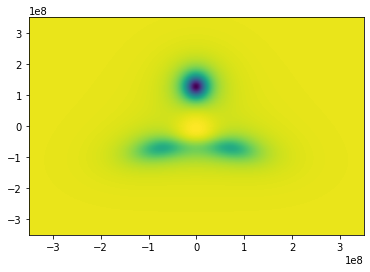

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.pcolormesh(kx, ky, Omega[1])

In [18]:
Omega.sum(ai)

ValueError: output parameter for reduction operation add has too many dimensions

# Try einsum again to eliminate double for

In [15]:
from blg_strain.hamiltonian import H_dkx, H_dky

In [16]:
hdkx, hdky = H_dkx(), H_dky()

In [18]:
Enm = E.reshape(4,1, E.shape[-2], E.shape[-1]) - E.reshape(1,4, E.shape[-2], E.shape[-1])
Enm.shape

(4, 4, 1000, 1000)

In [19]:
for i in range(4):
    Enm[i,i,:,:] = 1e100
# when dividing by Enm, diagonal components (n=m) will go to zero

In [20]:
prod1 = np.einsum('nikl,ij,mjkl->nmkl', Psi.conj(), hdkx, Psi)
prod2 = np.einsum('mikl,ij,njkl->nmkl', Psi.conj(), hdky, Psi)
prod = np.sum(np.imag(prod1*prod2/Enm), axis=1)  # sum over m

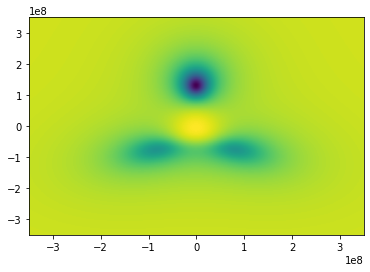

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.pcolormesh(kx, ky, prod[1])

# Spline integration

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

from blg_strain.bands import get_bands
from blg_strain.berry import berry_mu

In [75]:
%matplotlib notebook

In [76]:
kx, ky, Kx, Ky, E, Psi = get_bands(Delta=0.02, delta=0.01)
Omega, Mu = berry_mu(E, Psi)

<IPython.core.display.Javascript object>


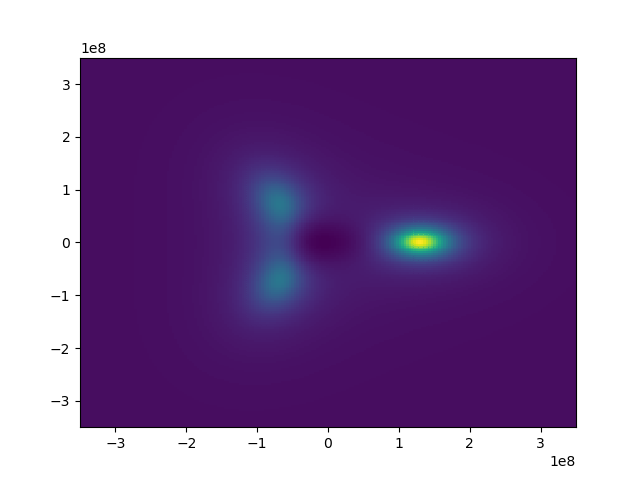

In [77]:
fig, ax = plt.subplots()
ax.pcolormesh(Kx, Ky, Omega[2])

In [11]:
from blg_strain.microscopic import feq_func

In [17]:
%%timeit
EF = 0.03
T = 0

feq = feq_func(E, EF, T)

11.4 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


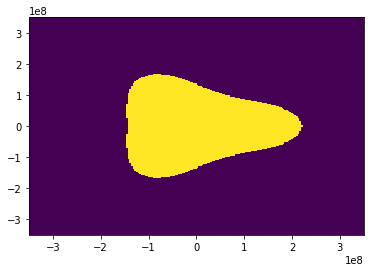

In [18]:
fig, ax = plt.subplots()
ax.pcolormesh(Kx, Ky, feq[2])

In [21]:
%%timeit
spl = RectBivariateSpline(kx, ky, Omega[2])

2.24 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
spl = RectBivariateSpline(kx, ky, Omega[2])

In [37]:
kxdense = np.linspace(kx.min(), kx.max(),1000)
kydense = np.linspace(ky.min(), ky.max(),1000)

In [38]:
%%timeit
spl(kxdense, kydense, dx=1)

14.2 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
Omega_dkx = spl(kxdense, kydense, dx=1)

In [41]:
%%timeit
RectBivariateSpline(kxdense, kydense, Omega_dkx * feq[2])

ValueError: operands could not be broadcast together with shapes (1000,1000) (200,200) 

In [28]:
spl2 = RectBivariateSpline(kx, ky, Omega_dkx * feq[2])

In [29]:
%%timeit
spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())

50.8 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<IPython.core.display.Javascript object>


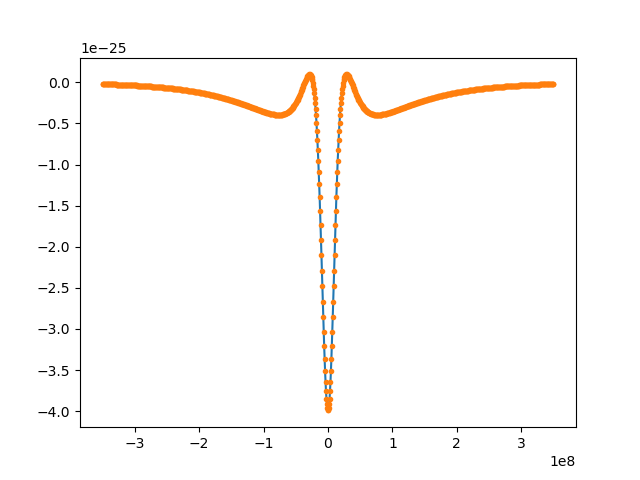

In [78]:
j = 684

fig, ax = plt.subplots()
ax.plot(kydense, Omega_dkx[j, :])
ax.plot(kydense, spl(kxdense[j], kydense, dx=1)[0], '.')

## Dipole

In [116]:
def D_valley(kx, ky, E, Omega, EF=0, T=0):
       
    N = E.shape[0]  # 4
    D = np.empty(N)
    
    kxdense = np.linspace(kx.min(), kx.max(), 1000)
    kydense = np.linspace(ky.min(), ky.max(), 1000)
    
    for n in range(N):
        
        spl_E = RectBivariateSpline(kx, ky, E[n])
        f = feq_func(spl_E(kxdense, kydense), EF, T)
        
        spl = RectBivariateSpline(kx, ky, Omega[n])
        Omega_dkx = spl(kxdense, kydense, dx=1)
        spl2 = RectBivariateSpline(kxdense, kydense, Omega_dkx * f)  # integrand
        D[n] = spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())
        
    return D  # not summed over bands

In [117]:
EF = np.linspace(.01, .05, 41)
Ds = []
for ef in EF:
    Ds.append(D_valley(kx, ky, E, Omega, EF=ef, T=1)[2])

c:\users\brian\documents\github\blg_strain\blg_strain\microscopic.py:57: RuntimeWarning: overflow encountered in exp
  f = 1 / (1 + np.exp((E - EF) / (kB * T)))


<IPython.core.display.Javascript object>


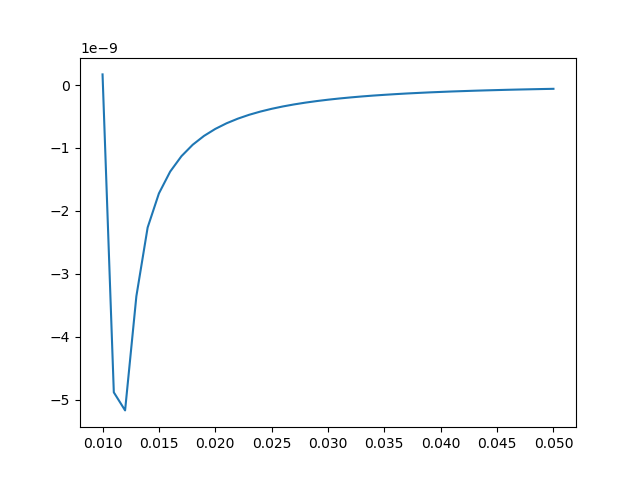

In [119]:
fig, ax = plt.subplots()
ax.plot(EF, Ds, '-')

This works! How to make it fast?

In [134]:
from blg_strain.utils.const import kB

In [135]:
ef, T = 0.02, 1

In [309]:
kxdense = np.linspace(kx.min(), kx.max(), 1000)
kydense = np.linspace(ky.min(), ky.max(), 1000)

Kxdense, Kydense = np.meshgrid(kxdense, kydense, indexing='ij')
spl_E = RectBivariateSpline(kx, ky, E[n])

In [153]:
f = feq_func(spl_E(kxdense, kydense), ef, T)

In [243]:
%%prun
N = E.shape[0]  # 4
D = np.empty(N)

kxdense = np.linspace(kx.min(), kx.max(), 1000)
kydense = np.linspace(ky.min(), ky.max(), 1000)

for n in range(N):
    spl_E = RectBivariateSpline(kx, ky, E[n])
    f = feq_func(spl_E(kxdense, kydense), ef, T)

    spl = RectBivariateSpline(kx, ky, Omega[n])
    Omega_dkx = spl(kxdense, kydense, dx=1)
    spl2 = RectBivariateSpline(kxdense, kydense, Omega_dkx * f)  # integrand
    D[n] = spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())

c:\users\brian\documents\github\blg_strain\blg_strain\microscopic.py:57: RuntimeWarning: overflow encountered in exp
  f = 1 / (1 + np.exp((E - EF) / (kB * T)))


In [290]:
n, eF, T = 2, 0.02, 1

In [291]:
%%timeit
spl_E = RectBivariateSpline(kx, ky, E[n])

2.34 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [292]:
spl_E = RectBivariateSpline(kx, ky, E[n])

In [293]:
%%timeit
f = feq_func(spl_E(kxdense, kydense), ef, T)

c:\users\brian\documents\github\blg_strain\blg_strain\microscopic.py:57: RuntimeWarning: overflow encountered in exp
  f = 1 / (1 + np.exp((E - EF) / (kB * T)))


69.9 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [294]:
f = feq_func(spl_E(kxdense, kydense), ef, T)

In [295]:
%%timeit 
spl = RectBivariateSpline(kx, ky, Omega[n])

2.88 ms ± 334 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [296]:
spl = RectBivariateSpline(kx, ky, Omega[n])

In [297]:
%%timeit
Omega_dkx = spl(kxdense, kydense, dx=1)

14.8 ms ± 758 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [298]:
Omega_dkx = spl(kxdense, kydense, dx=1)

In [299]:
%%timeit
Omega_dkx * f

4.89 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


integrate using the spline - creating the spline is expensive

In [312]:
%%timeit
spl2 = RectBivariateSpline(kxdense, kydense, Omega_dkx * f)  # integrand
D = spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())

129 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [313]:
%%timeit
D = spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())

3.43 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


or integrate using simps

In [314]:
from scipy.integrate import simps

C:\Users\Brian\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [318]:
%%timeit
simps(simps(Omega_dkx*f, x=kxdense, axis=-2), x=kydense, axis=-1)

43.4 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


make sure the results are the same

In [319]:
spl2.integral(kx.min(), kx.max(), ky.min(), ky.max())

-6.98239186103254e-10

In [321]:
simps(simps(Omega_dkx*f, kydense), kxdense)

-6.982391861033004e-10

<IPython.core.display.Javascript object>


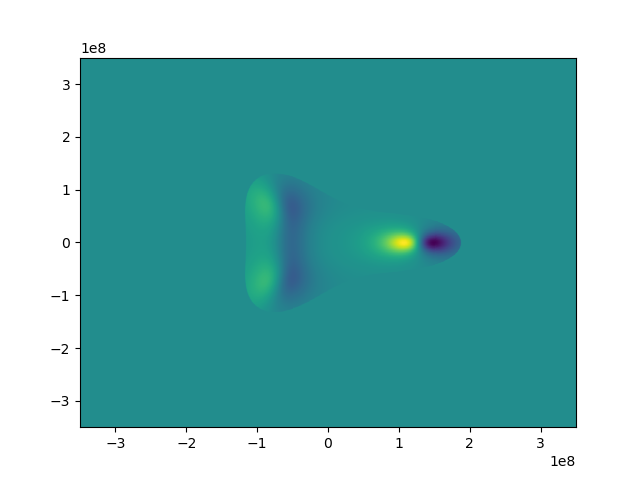

In [311]:
fig, ax = plt.subplots()
ax.pcolormesh(Kxdense, Kydense, Omega_dkx * f)

# Test Berry curvature dipole code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

from blg_strain.bands import get_bands
from blg_strain.berry import berry_mu

In [2]:
%matplotlib notebook

In [3]:
kx, ky, Kx, Ky, E, Psi = get_bands(Delta=0.02, delta=0.01)
Omega, Mu = berry_mu(E, Psi)

In [4]:
from blg_strain.macroscopic import D_valley

In [30]:
import time

In [31]:
EF = np.linspace(.01, .05, 41)
Ds = []
ts = []

for ef in EF:
    t0 = time.time()
    Ds.append(D_valley(kx, ky, E, Omega, EF=ef, T=0)[2])
    ts.append(time.time()-t0)

<IPython.core.display.Javascript object>


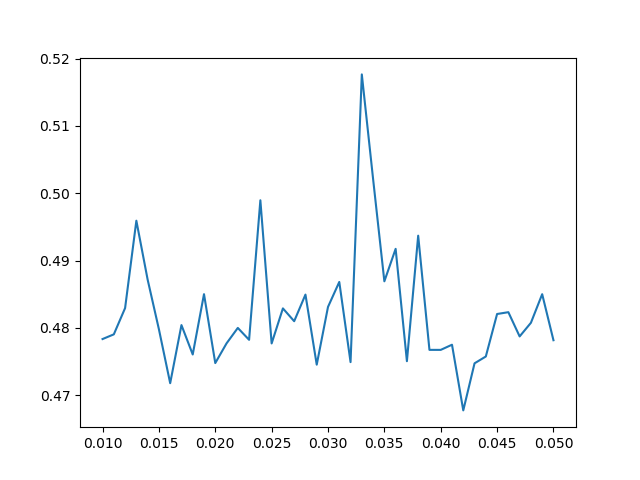

In [32]:
fig, ax = plt.subplots()
ax.plot(EF, ts)

<IPython.core.display.Javascript object>


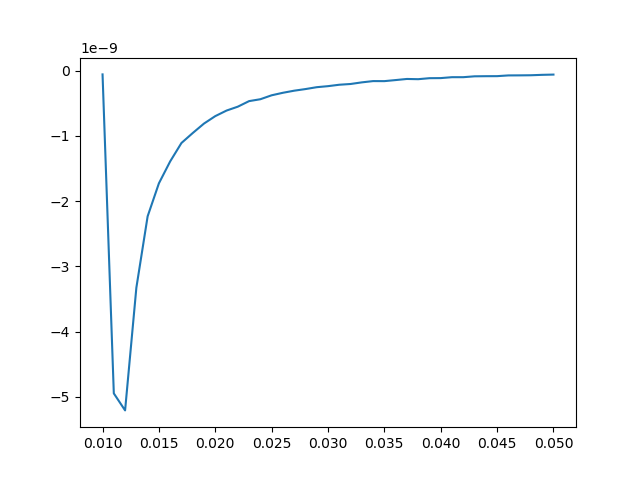

In [29]:
fig, ax = plt.subplots()
ax.plot(EF, Ds)

# Rewrite Berry curvature dipole function to accept already dense kx, ky grid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

from blg_strain.bands import get_bands
from blg_strain.berry import berry_mu
from blg_strain.utils.utils import get_splines
from blg_strain.utils.utils import densify
from blg_strain.microscopic import feq_func
from blg_strain.macroscopic import D_valley, ntot_func, D_func

In [2]:
%matplotlib notebook

In [24]:
Delta = 0.02
delta = 0.02

# K
kx, ky, Kx, Ky, E, Psi = get_bands(Delta=Delta, delta=delta)
Omega, Mu = berry_mu(E, Psi)
splE, splO, splM = get_splines(kx, ky, E, Omega, Mu)
kx2, ky2, E2, Omega2, Mu2 = densify(kx, ky, splE, splO, splM)

# K'
kx1, ky1, Kx1, Ky1, E1, Psi1 = get_bands(xi=-1, Delta=Delta, delta=delta)
Omega1, Mu1 = berry_mu(E1, Psi1)
splE1, splO1, splM1 = get_splines(kx1, ky1, E1, Omega1, Mu1)
kx12, ky12, E12, Omega12, Mu12 = densify(kx1, ky1, splE1, splO1, splM1)

In [25]:
EFs = np.linspace(0, 0.05, 21)

ntot = np.empty_like(EFs)
D = np.empty_like(EFs)
D1 = np.empty_like(EFs)

T=0
for i, EF in enumerate(EFs):
    f = feq_func(E2, EF, T=T)
    f1 = feq_func(E12, EF, T=T)
    ntot[i] = ntot_func(kx2, ky2, f, f1, EF, T=T)
    D[i] = D_valley(kx2, ky2, f, splO)[2]
    D1[i] = D_valley(kx2, ky2, f1, splO1)[2]

<IPython.core.display.Javascript object>


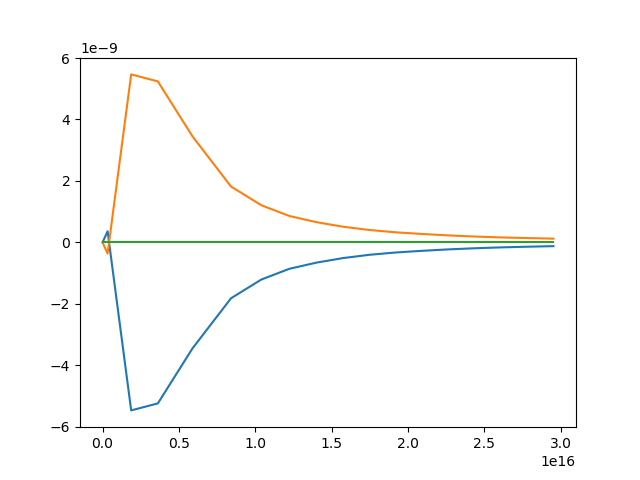

In [26]:
fig, ax = plt.subplots()
ax.plot(ntot, D)
ax.plot(ntot, D1)
ax.plot(ntot, D + D1)

<IPython.core.display.Javascript object>


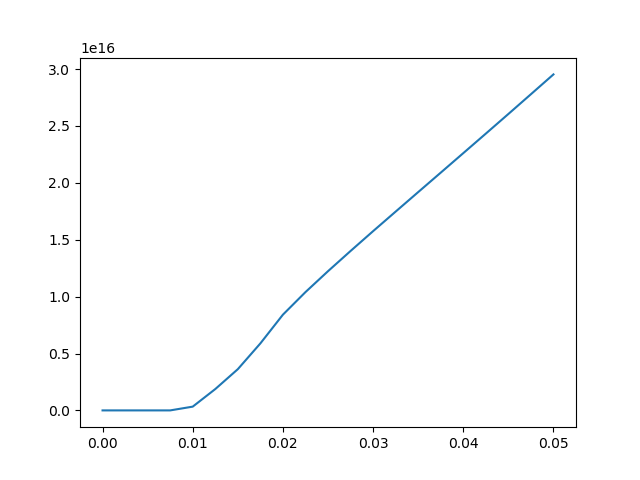

In [27]:
fig, ax = plt.subplots()
ax.plot(EFs, ntot)

## Troubleshoot D

In [29]:
Omega_dkx = splO[2](kx, ky, dx=1)

<IPython.core.display.Javascript object>


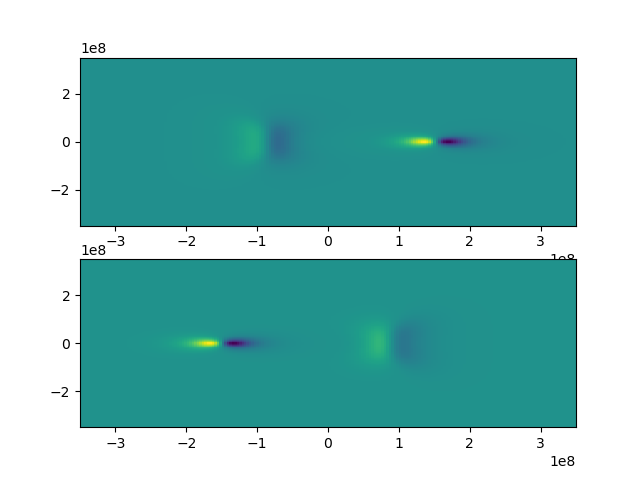

In [35]:
fig, ax = plt.subplots(2)
ax[0].pcolormesh(kx, ky, splO[2](kx, ky, dx=1).T)
ax[1].pcolormesh(kx, ky, splO1[2](kx, ky, dx=1).T)

In [32]:
from scipy.integrate import simps

<IPython.core.display.Javascript object>


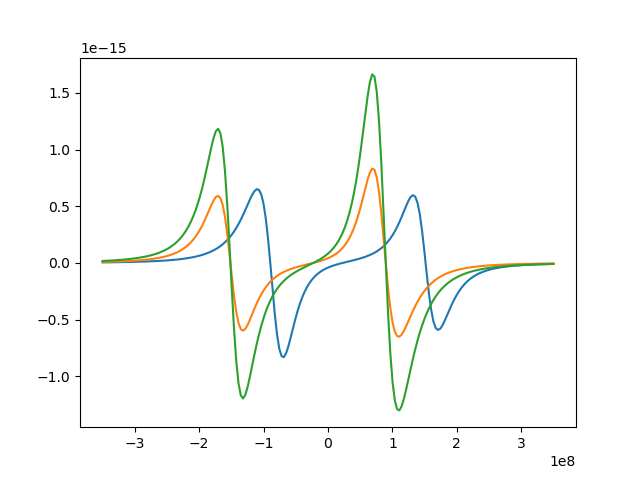

In [38]:
fig, ax = plt.subplots()
ax.plot(kx, simps(splO[2](kx, ky, dx=1), ky))
ax.plot(kx, simps(splO1[2](kx, ky, dx=1), ky))

<IPython.core.display.Javascript object>


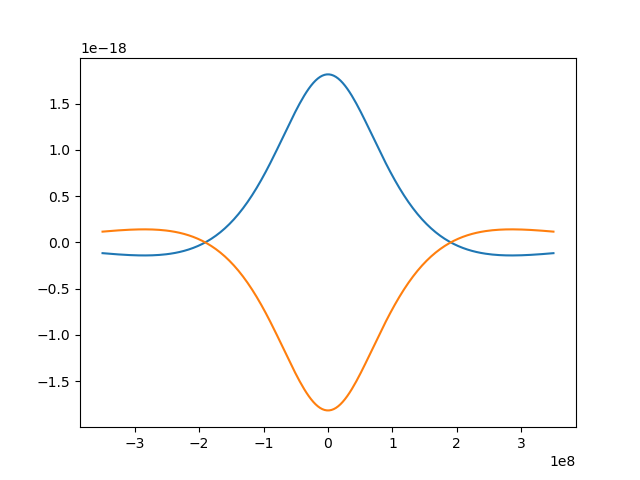

In [39]:
fig, ax = plt.subplots()
ax.plot(ky, simps(splO[2](kx, ky, dx=1), kx, axis=-2))
ax.plot(ky, simps(splO1[2](kx, ky, dx=1), kx, axis=-2))

Should one of the valleys have a negative sign?

# Compare to Battilomo using only one valley

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

from blg_strain.bands import get_bands
from blg_strain.berry import berry_mu
from blg_strain.utils.utils import get_splines
from blg_strain.utils.utils import densify
from blg_strain.microscopic import feq_func
from blg_strain.macroscopic import D_valley, ntot_func, D_func, n_valley

In [3]:
%matplotlib notebook

In [10]:
from blg_strain.utils.const import hbar, v3
kL = 0.035e9  # m^-1
EL = hbar * kL * v3 / 2

In [11]:
from blg_strain.utils.params import w

In [20]:
w(1, 3, 1, 0).real / EL  # Value of w3 (in EL) for 100% strain

468.7199049518566

In [26]:
wEL = 5
delta = wEL / (w(1,3,1,0).real / EL)  # delta corresponding to value of wEL
delta

0.010667351540177417

In [29]:
wELs = np.array([1,3,5])
deltas = wELs/ (w(1,3,1,0).real / EL)

In [40]:
Delta = 0.01
EFs = np.linspace(0, 0.013, 21)


Ds = []
ntots = []

for delta in deltas:

    # K
    kx, ky, Kx, Ky, E, Psi = get_bands(Delta=Delta, delta=delta)
    Omega, Mu = berry_mu(E, Psi)
    splE, splO, splM = get_splines(kx, ky, E, Omega, Mu)
    kx2, ky2, E2, Omega2, Mu2 = densify(kx, ky, splE, splO, splM)
    
    ntot = np.empty_like(EFs)
    D = np.empty_like(EFs)

    T=0
    for i, EF in enumerate(EFs):
        f = feq_func(E2, EF, T=T)
        ntot[i] = n_valley(kx2, ky2, f, EF, T=T)
        D[i] = D_valley(kx2, ky2, f, splO)[2]
    
    Ds.append(D)
    ntots.append(ntot)

<IPython.core.display.Javascript object>


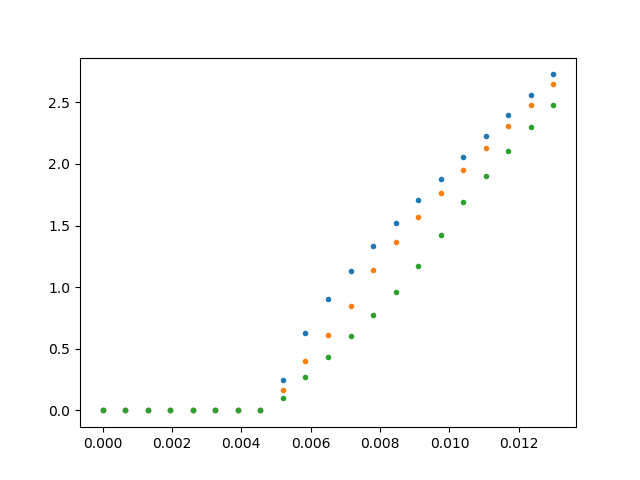

In [43]:
fig, ax = plt.subplots()
for ntot in ntots:
    ax.plot(EFs, ntot / kL**2, '.')

<IPython.core.display.Javascript object>


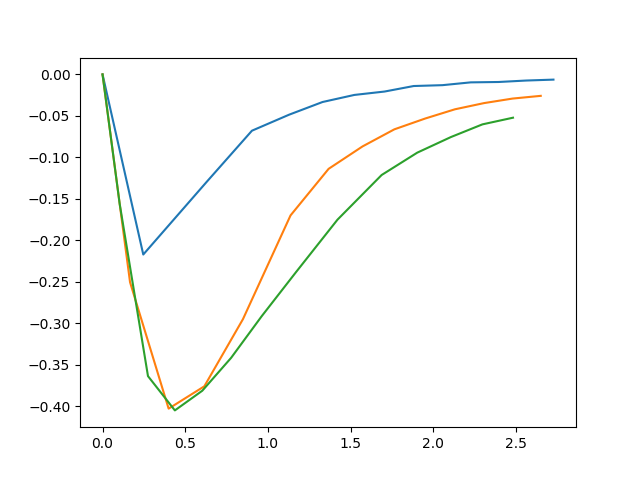

In [45]:
fig, ax = plt.subplots()

for ntot, D in zip(ntots, Ds):
    ax.plot(ntot / kL ** 2, D * kL)

# Try 2x2 Hamiltonian

In [1]:
from blg_strain.bands import get_bands

In [2]:
from blg_strain.hamiltonian import Hfunc

In [3]:
import numpy as np

In [4]:
Kx, Ky = np.meshgrid(np.linspace(0,1), np.linspace(0,1))

In [5]:
H = Hfunc(Kx, Ky, xi=1, twobytwo=True)

In [6]:
H.shape

(2, 2, 50, 50)

In [7]:
kx, ky, Kx, Ky, E, Psi = get_bands(delta=0.02, Delta=0.02, twobytwo=True)

In [8]:
import matplotlib.pyplot as plt

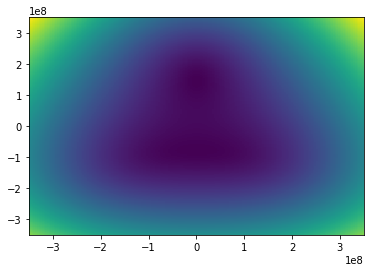

In [9]:
fig, ax = plt.subplots()
ax.pcolormesh(kx, ky, E[1])

In [10]:
from blg_strain.berry import berry_mu

In [11]:
from blg_strain.hamiltonian import H2_dkx, H2_dky

In [12]:
h2dkx, h2dky = H2_dkx(Kx, Ky), H2_dky(Kx, Ky)

In [13]:
h2dkx.shape

(2, 2, 200, 200)

In [14]:
Omega, Mu = berry_mu(Kx, Ky, E, Psi)

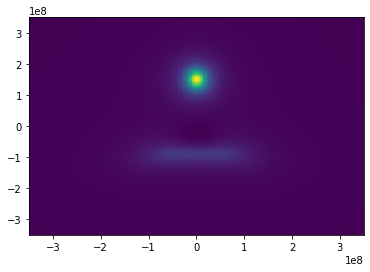

In [17]:
fig, ax = plt.subplots()
ax.pcolormesh(kx, ky, Omega[0])